# Advanced Modeling

- In the last milestone, we came up with the conclusion that Linear Regression models aren't well suited for sequential data modeling, especially time series forecasting. 
- Even though the weather conditions are very tough to model (otherwise, we would have a perfect weather system prediction model.), we will attempt to apply the models that are popular in the deep learning and computer vision fields like RNN, LSTM, LSTM with Attention, etc.

## Install required libraries and [Contourf and cartopy issues resolved](https://linuxtut.com/en/8f0d69169dc6ab753e08/)

In [1]:
!pip install xarray
!pip install cartopy

!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get -qq update

!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

!apt-get -qq build-dep python3-cartopy
!apt-get -qq remove python-shapely python3-shapely

!pip install --no-binary shapely shapely --force
!pip install --no-binary cartopy cartopy==0.19.0

!pip list | grep Shapely

     |████████████████████████████████| 10.8 MB 19.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 36.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 30.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 22.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 3.1 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516276 sha256=5309b3c01602067e9410d1b0320cc9ced3e06d72439ab74bce2df9939719a3ab
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
deb-src 

## get data of Mahad 

- The `tp` parameter is in `mm` units, instead of `m` units, which were in the initial Linear Regression model.
- The data preparation has also been done for the LSTM. The data needs to be converted to the sequences. 
- So, I have chosen the Mahad's sequential data of only 'total precipitation (tp)' over 2021. 
- The data sequences have **three** dimensions (`n_batches`, `lag`, `features`). Here, since we are considering `tp` only, the feature is 1. 
- I have chosen the `lag` to be **$4$**, i.e. looking at the 4 hours of the rain, predict the next hour's rain.  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# intall libraries
import numpy as np  # import numpy package 
import matplotlib.pyplot as plt # function in matplotlib that produces quick and easy plots
import pandas as pd # load the Pandas module, which is a library for data manipulation of 2 dimensional data
import xarray as xr # load the xarray module, which is a library for data manipulation of N dimensional data
import cartopy.crs as ccrs # Cartopy map projections
import cartopy.feature as cfeature # Cartopy map features
from cartopy.util import add_cyclic_point
import cartopy
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# open_dataset is one of the main functions in Xarray to open a Netcdf file.  
data = xr.open_dataset('download.nc') # open the dataset
data 

# let's separate the data according to years
data_2019 = data.sel(time=data.time.dt.year == 2019)
data_2020 = data.sel(time=data.time.dt.year == 2020)
data_2021 = data.sel(time=data.time.dt.year == 2021)

In [3]:
lat = data.latitude.values
lon = data.longitude.values
# Find the indices of the nearest gridpoint to Mahad. Save these indices to new variables, and print out the values. 
lat_mahad = 18.1
# longitude of mahad in eastward
lon_mahad = 73.4
# find the indices of the nearest gridpoint to mahad
lat_ind = np.abs(lat - lat_mahad).argmin()
lon_ind = np.abs(lon - lon_mahad).argmin()
# print the values of the indices
print(f"The latitude index of the nearest gridpoint to Mahad is: {lat_ind}")
print(f"The longitude index of the nearest gridpoint to Mahad is: {lon_ind}")
# Print the corresponding lat/lon of that gridpoint.
print(f"The corresponding lat/lon of that gridpoint is: {lat[lat_ind]}, {lon[lon_ind]}")

# Index your data so that you are only accessing data at this special location.
data_mahad_2019 = data_2019.sel(latitude=lat[lat_ind], longitude=lon[lon_ind])
data_mahad_2020 = data_2020.sel(latitude=lat[lat_ind], longitude=lon[lon_ind])
data_mahad_2021 = data_2021.sel(latitude=lat[lat_ind], longitude=lon[lon_ind])

# convert tp variable of each data of mahad to mm units from m 
data_mahad_2019['tp'] = data_mahad_2019['tp'] * 1000
data_mahad_2020['tp'] = data_mahad_2020['tp'] * 1000
data_mahad_2021['tp'] = data_mahad_2021['tp'] * 1000


The latitude index of the nearest gridpoint to Mahad is: 39
The longitude index of the nearest gridpoint to Mahad is: 14
The corresponding lat/lon of that gridpoint is: 18.100000381469727, 73.4000015258789


In [4]:
data_mahad_2019

<xarray.Dataset>
Dimensions:    (time: 264)
Coordinates:
    longitude  float32 73.4
    latitude   float32 18.1
  * time       (time) datetime64[ns] 2019-07-14 ... 2019-07-24T23:00:00
Data variables:
    v10        (time) float32 ...
    t2m        (time) float32 ...
    ssr        (time) float32 ...
    sp         (time) float32 ...
    tp         (time) float32 14.79 0.7439 1.312 2.258 ... 36.99 38.04 38.65
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-23 20:02:03 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [5]:
data_mahad_2021

<xarray.Dataset>
Dimensions:    (time: 264)
Coordinates:
    longitude  float32 73.4
    latitude   float32 18.1
  * time       (time) datetime64[ns] 2021-07-14 ... 2021-07-24T23:00:00
Data variables:
    v10        (time) float32 ...
    t2m        (time) float32 ...
    ssr        (time) float32 ...
    sp         (time) float32 ...
    tp         (time) float32 68.93 1.682 3.105 4.643 ... 18.27 18.97 19.9 20.92
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-23 20:02:03 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [6]:
# save data_mahad_2021.tp to csv
data_mahad_2021_tp_df = data_mahad_2021['tp'].to_dataframe()
data_mahad_2021_tp_df = data_mahad_2021_tp_df.drop(['longitude', 'latitude'], axis=1)
data_mahad_2021_tp_df


,tp
time,
2021-07-14 00:00:00,68.929153
2021-07-14 01:00:00,1.682311
2021-07-14 02:00:00,3.105216
2021-07-14 03:00:00,4.642576
2021-07-14 04:00:00,7.187031
...,...
2021-07-24 19:00:00,16.914703
2021-07-24 20:00:00,18.272764
2021-07-24 21:00:00,18.970869


In [7]:
data_mahad_2021_tp_df.to_csv('data/data_mahad_2021_tp.csv', index=True, header=True)

In [8]:
pd.read_csv('data/data_mahad_2021_tp.csv', index_col=0)

,tp
time,
2021-07-14 00:00:00,68.929150
2021-07-14 01:00:00,1.682311
2021-07-14 02:00:00,3.105216
2021-07-14 03:00:00,4.642576
2021-07-14 04:00:00,7.187031
...,...
2021-07-24 19:00:00,16.914703
2021-07-24 20:00:00,18.272764
2021-07-24 21:00:00,18.970870


In [9]:
# copy the data folder to the folder in the google drive
!cp -r data/ /content/gdrive/My\ Drive/ATMS\ Project/univariate/data

## Training

In [10]:
# import the libraries
import os
import random
import numpy as np

from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # for evaluation

import torch # torch is a deep learning framework

from models import DNN, RNN, LSTM, AttentionalLSTM, CNN # import the models
from utils import make_dirs, load_data, plot_full, data_loader, split_sequence_uni_step, split_sequence_multi_step # import the utils
from utils import get_lr_scheduler, mean_percentage_error, mean_absolute_percentage_error, plot_pred_test # import the utils

# Reproducibility #
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

# Device Configuration #
device = 'cuda' if torch.cuda.is_available() else 'cpu' # use GPU if available


- The data has been scaled using MinMaxScaler, and loaded in the PyTorch. 
- I have also split the data into train, valid and test data. 
- So, the training will occur on the train data and evaluate the model using the validation data, telling us about the overfitting or underfitting. 
- We will infer on the new test data after the model has been trained.

In [39]:
# Global variables #
SEED = 42
FEATURE = 'tp' # for the feature we want to predict
MULTI_STEP = False # if we want to predict the next value of the feature
SEQ_LENGTH = 4 # length of the sequence
BATCH_SIZE = 8 # batch size
PLOT_FULL = False # if we want to plot the full data
# MODE = 'train' # train or test
MODEL_MAP = {
    'LSTM': LSTM,
    'RNN': RNN,
    'DNN': DNN,
    'AttentionalLSTM': AttentionalLSTM,
    'CNN': CNN
}
INPUT_SIZE = 1 # input size of the model, number of features
HIDDEN_SIZE = 4 # hidden size of the model
NUM_LAYERS = 1 # number of layers of the model
OUTPUT_SIZE = 1 # output size of the model
BIDIRECTIONAL = False # if we want to use bidirectional LSTM
QKV = 5 # number of QKV for the attentional LSTM
WEIGHTS_PATH = 'weights/' # path to save the weights
PLOTS_PATH = 'plots/' # path to save the plots
NUMPY_PATH = 'numpy/' # path to save the numpy files
TRAIN_SPLIT = 0.8 # train split
TEST_SPLIT = 0.5 # test split

TIME_PLOT = 100 # time stamp for the plot
NUM_EPOCHS = 100 # number of epochs
PRINT_EVERY = 10 # print every
LR = 0.001 # learning rate
LR_SCHEDULER = 'cosine' # learning rate scheduler

In [40]:
# data = load_data('data/data_mahad_2021_tp.csv')
# data.values.shape

In [41]:
# def train function
def train(model_name, mode='train'):
    # seed the random number generator
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    # paths for weights and plots and numpy files
    paths = [WEIGHTS_PATH, PLOTS_PATH, NUMPY_PATH]
    # for each path in paths
    for path in paths:
        # make the directory if it does not exist
        make_dirs(path)
    
    # DATA PREPARATION #
    # load the data
    data = load_data('data/data_mahad_2021_tp.csv')
    data = data.copy()

    # Plot the full data if we want to
    if PLOT_FULL:
        plot_full(data, FEATURE)
    
    scaler = MinMaxScaler() # create a MinMaxScaler object
    data = scaler.fit_transform(data) # fit and transform the data
    print(data.shape)  # print the shape of the data

    # split the data into train and test and validation
    copied_data = data.copy()

    if MULTI_STEP:
        # Split the data into X and y
        X, y = split_sequence_multi_step(copied_data, SEQ_LENGTH, OUTPUT_SIZE) # split the data into X and y
        step = 'Multi-step'
    else:
        # Split the data into X and y 
        X, y = split_sequence_uni_step(copied_data, SEQ_LENGTH)
        step = 'Uni-step'
    
    # load the data
    train_loader, val_loader, test_loader = data_loader(X, y, TRAIN_SPLIT, TEST_SPLIT, BATCH_SIZE)
    # print the shapes of the data loaders
    print('Train loader shape:', len(train_loader))
    print('Val loader shape:', len(val_loader))
    print('Test loader shape:', len(test_loader))


    # list of losses of train and validation
    train_losses, val_losses = [], []
    val_maes, val_mses, val_rmses, val_mapes, val_mpes, val_r2s = list(), list(), list(), list(), list(), list()
    test_maes, test_mses, test_rmses, test_mapes, test_mpes, test_r2s = list(), list(), list(), list(), list(), list()
    pred_tests, labels = list(), list()

    # validation loss improvement
    best_val_loss = 100
    best_val_improv = 0

    # create the model
    if model_name == 'DNN':
        model = MODEL_MAP[model_name](SEQ_LENGTH, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    elif model_name == 'CNN':
        model = MODEL_MAP[model_name](SEQ_LENGTH, BATCH_SIZE, OUTPUT_SIZE).to(device)
    elif model_name == 'RNN':
        model = MODEL_MAP[model_name](INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
    elif model_name == 'LSTM':
        model = MODEL_MAP[model_name](INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, BIDIRECTIONAL).to(device)
    elif model_name == 'AttentionalLSTM':
        model = MODEL_MAP[model_name](INPUT_SIZE, QKV, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, BIDIRECTIONAL).to(device)
    else:
        raise NotImplementedError

    # criterion 
    criterion = torch.nn.MSELoss()

    # optimizer
    optim = torch.optim.Adam(model.parameters(), lr=LR, betas = (0.5, 0.999))
    optim_scheduler = get_lr_scheduler(LR_SCHEDULER, optim)

    # Train and validate the model
    if mode == 'train':
        print("Training {} using {} started with total epoch of {}.".format(model.__class__.__name__, step, NUM_EPOCHS))
        for epoch in range(NUM_EPOCHS):
            for i, (data, label) in enumerate(train_loader):
                # data and label
                data = data.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.float32)

                # free up unnecessary memory of cuda
                torch.cuda.empty_cache()

                # zero the gradients
                optim.zero_grad()

                # pass the data to the model
                pred = model(data)

                # calculate the loss
                train_loss = criterion(pred, label)

                # Backpropagation
                train_loss.backward()
                optim.step()

                # append the loss to the list
                train_losses.append(train_loss.item())
            # print 
            if (epoch+1) % PRINT_EVERY == 0:
                print("Epoch [{}/{}]".format(epoch+1, NUM_EPOCHS))
                print("Train Loss {:.4f}".format(np.average(train_losses)))
            
            # LEARNING RATE SCHEDULER
            optim_scheduler.step()

            # validation
            with torch.no_grad():
                for i, (data, label) in enumerate(val_loader):
                    # data and label
                    data = data.to(device, dtype=torch.float32)
                    label = label.to(device, dtype=torch.float32)

                    # pass the data to the model
                    pred_val = model(data)

                    # calculate the loss
                    val_loss = criterion(pred_val, label)

                    if MULTI_STEP:
                        pred_val = np.mean(pred_val.detach().cpu().numpy(), axis=1)
                        label = np.mean(label.detach().cpu().numpy(), axis=1)
                    else:
                        pred_val = pred_val.cpu()
                        label = label.cpu()
                    
                    # print
                    val_mae = mean_absolute_error(label, pred_val)
                    val_mse = mean_squared_error(label, pred_val, squared=True)
                    val_rmse = mean_squared_error(label, pred_val, squared=False)
                    val_mpe = mean_percentage_error(label, pred_val)
                    val_mape = mean_absolute_percentage_error(label, pred_val)
                    val_r2 = r2_score(label, pred_val)

                    # Add item to Lists #
                    val_losses.append(val_loss.item())
                    val_maes.append(val_mae.item())
                    val_mses.append(val_mse.item())
                    val_rmses.append(val_rmse.item())
                    val_mpes.append(val_mpe.item())
                    val_mapes.append(val_mape.item())
                    val_r2s.append(val_r2)
            if (epoch+1) % PRINT_EVERY == 0:
                print("Val Loss {:.4f}".format(np.average(val_losses)))
                print(" MAE : {:.4f}".format(np.average(val_maes)))
                print(" MSE : {:.4f}".format(np.average(val_mses)))
                print("RMSE : {:.4f}".format(np.average(val_rmses)))
                print(" MPE : {:.4f}".format(np.average(val_mpes)))
                print("MAPE : {:.4f}".format(np.average(val_mapes)))
                print(" R^2 : {:.4f}".format(np.average(val_r2s)))

                # save model if validation loss improves
                curr_val_loss = np.average(val_losses)

                if curr_val_loss < best_val_loss:
                    best_val_loss = min(curr_val_loss, best_val_loss)
                    torch.save(model.state_dict(), os.path.join(WEIGHTS_PATH, 'BEST_{}_using_{}.pkl'.format(model.__class__.__name__, step)))
                    print("Saved model with best validation loss.")
                    best_val_improv = 0
                elif curr_val_loss >= best_val_loss:
                    best_val_improv += 1
                    print("No improvement in validation loss for {} epochs.".format(best_val_improv))
    
    # Test the model
    elif mode == 'test':
        # load the model weights from the best model
        model.load_state_dict(torch.load(os.path.join(WEIGHTS_PATH, 'BEST_{}_using_{}.pkl'.format(model.__class__.__name__, step))))

        with torch.no_grad():
            for i, (data, label) in enumerate(test_loader):
                # Prepare Data #
                data = data.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.float32)

                # Forward Data #
                pred_test = model(data)

                # Convert to Original Value Range #
                pred_test, label = pred_test.detach().cpu().numpy(), label.detach().cpu().numpy()

                pred_test = scaler.inverse_transform(pred_test)
                label = scaler.inverse_transform(label)

                if MULTI_STEP:
                    pred_test = np.mean(pred_test, axis=1)
                    label = np.mean(label, axis=1)

                pred_tests += pred_test.tolist()
                labels += label.tolist()

                # Calculate Loss #
                test_mae = mean_absolute_error(label, pred_test)
                test_mse = mean_squared_error(label, pred_test, squared=True)
                test_rmse = mean_squared_error(label, pred_test, squared=False)
                test_mpe = mean_percentage_error(label, pred_test)
                test_mape = mean_absolute_percentage_error(label, pred_test)
                test_r2 = r2_score(label, pred_test)

                # Add item to Lists #
                test_maes.append(test_mae.item())
                test_mses.append(test_mse.item())
                test_rmses.append(test_rmse.item())
                test_mpes.append(test_mpe.item())
                test_mapes.append(test_mape.item())
                test_r2s.append(test_r2.item())
            
            # Print Results #
            print("Test {} using {}".format(model.__class__.__name__, step))
            print(" MAE : {:.4f}".format(np.average(test_maes)))
            print(" MSE : {:.4f}".format(np.average(test_mses)))
            print("RMSE : {:.4f}".format(np.average(test_rmses)))
            print(" MPE : {:.4f}".format(np.average(test_mpes)))
            print("MAPE : {:.4f}".format(np.average(test_mapes)))
            print(" R^2 : {:.4f}".format(np.average(test_r2s)))

            # Plot Figure #
            plot_pred_test(pred_tests[:TIME_PLOT], labels[:TIME_PLOT], PLOTS_PATH, FEATURE, model, step)

            # save numpy
            np.save(os.path.join(NUMPY_PATH, '{}_using_{}_TestSet.npy'.format(model.__class__.__name__, step)), np.asarray(pred_tests))
            np.save(os.path.join(NUMPY_PATH, 'TestSet_using_{}.npy'.format(step)), np.asarray(labels))
    else:
        raise NotImplementedError


In [42]:
train('DNN')

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Training DNN using Uni-step started with total epoch of 100.
Epoch [10/100]
Train Loss 0.3183
Val Loss 0.2873
 MAE : 0.5116
 MSE : 0.2873
RMSE : 0.5221
 MPE : 199.7680
MAPE : 199.7680
 R^2 : -410.0588
Saved model with best validation loss.
Epoch [20/100]
Train Loss 0.2320
Val Loss 0.2092
 MAE : 0.4254
 MSE : 0.2092
RMSE : 0.4362
 MPE : 147.3380
MAPE : 159.8677
 R^2 : -301.5484
Saved model with best validation loss.
Epoch [30/100]
Train Loss 0.1671
Val Loss 0.1465
 MAE : 0.3283
 MSE : 0.1465
RMSE : 0.3372
 MPE : 81.9558
MAPE : 143.8818
 R^2 : -209.4153
Saved model with best validation loss.
Epoch [40/100]
Train Loss 0.1332
Val Loss 0.1136
 MAE : 0.2724
 MSE : 0.1136
RMSE : 0.2813
 MPE : 43.6461
MAPE : 136.6880
 R^2 : -160.2304
Saved model with best validation loss.
Epoch [50/100]
Train Loss 0.1124
Val Loss 0.0933
 MAE : 0.2346
 MSE : 0.0933
RMSE : 0.2443
 MPE : 17.6496
MAPE : 132.6262
 R^2 : -129.5171
Saved model w

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Test DNN using Uni-step
 MAE : 6.6324
 MSE : 150.5028
RMSE : 7.7925
 MPE : -264.2234
MAPE : 267.9180
 R^2 : -1.4154


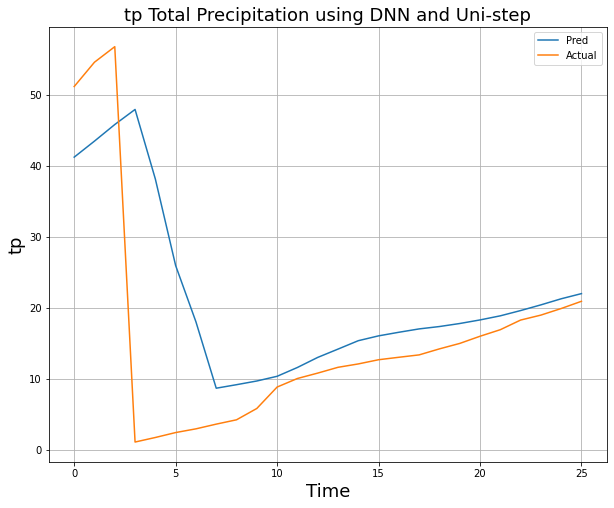

In [43]:
train('DNN', 'test')

In [44]:
train('RNN')

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Training RNN using Uni-step started with total epoch of 100.
Epoch [10/100]
Train Loss 0.0866
Val Loss 0.0291
 MAE : 0.1497
 MSE : 0.0291
RMSE : 0.1622
 MPE : -73.8204
MAPE : 117.2543
 R^2 : -36.8950
Saved model with best validation loss.
Epoch [20/100]
Train Loss 0.0811
Val Loss 0.0274
 MAE : 0.1446
 MSE : 0.0274
RMSE : 0.1570
 MPE : -76.0015
MAPE : 117.2367
 R^2 : -33.7686
Saved model with best validation loss.
Epoch [30/100]
Train Loss 0.0743
Val Loss 0.0253
 MAE : 0.1381
 MSE : 0.0253
RMSE : 0.1502
 MPE : -77.1125
MAPE : 116.1791
 R^2 : -30.6078
Saved model with best validation loss.
Epoch [40/100]
Train Loss 0.0695
Val Loss 0.0238
 MAE : 0.1336
 MSE : 0.0238
RMSE : 0.1455
 MPE : -77.6002
MAPE : 115.2579
 R^2 : -28.5480
Saved model with best validation loss.
Epoch [50/100]
Train Loss 0.0642
Val Loss 0.0222
 MAE : 0.1279
 MSE : 0.0222
RMSE : 0.1396
 MPE : -78.0910
MAPE : 114.0298
 R^2 : -26.2056
Saved model wit

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Test RNN using Uni-step
 MAE : 6.2943
 MSE : 121.5431
RMSE : 7.7411
 MPE : -238.7498
MAPE : 241.6030
 R^2 : -2.9949


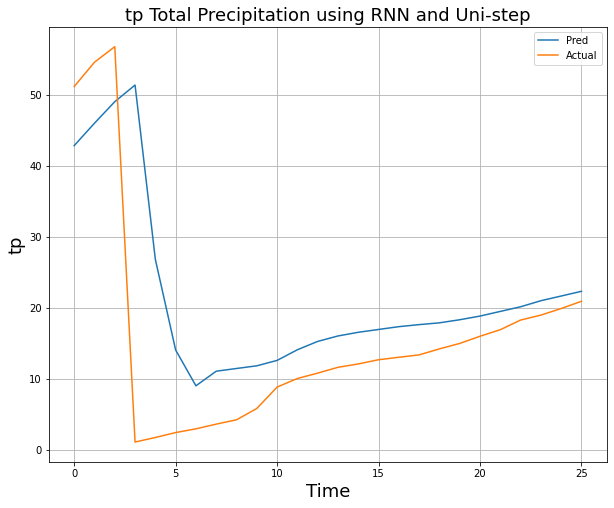

In [45]:
train('RNN', 'test')

In [46]:
train('CNN')

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Training CNN using Uni-step started with total epoch of 100.
Epoch [10/100]
Train Loss 0.0386
Val Loss 0.0142
 MAE : 0.0882
 MSE : 0.0142
RMSE : 0.1048
 MPE : -95.2047
MAPE : 115.6804
 R^2 : -9.6290
Saved model with best validation loss.
Epoch [20/100]
Train Loss 0.0354
Val Loss 0.0134
 MAE : 0.0828
 MSE : 0.0134
RMSE : 0.1003
 MPE : -94.4935
MAPE : 114.0776
 R^2 : -8.6050
Saved model with best validation loss.
Epoch [30/100]
Train Loss 0.0314
Val Loss 0.0121
 MAE : 0.0762
 MSE : 0.0121
RMSE : 0.0934
 MPE : -92.4886
MAPE : 111.5541
 R^2 : -7.1804
Saved model with best validation loss.
Epoch [40/100]
Train Loss 0.0288
Val Loss 0.0113
 MAE : 0.0720
 MSE : 0.0113
RMSE : 0.0887
 MPE : -90.6915
MAPE : 109.5486
 R^2 : -6.3208
Saved model with best validation loss.
Epoch [50/100]
Train Loss 0.0264
Val Loss 0.0105
 MAE : 0.0670
 MSE : 0.0105
RMSE : 0.0836
 MPE : -88.7628
MAPE : 106.6741
 R^2 : -5.5324
Saved model with bes

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Test CNN using Uni-step
 MAE : 5.8346
 MSE : 107.9795
RMSE : 7.9307
 MPE : -197.6372
MAPE : 208.2060
 R^2 : -9.0563


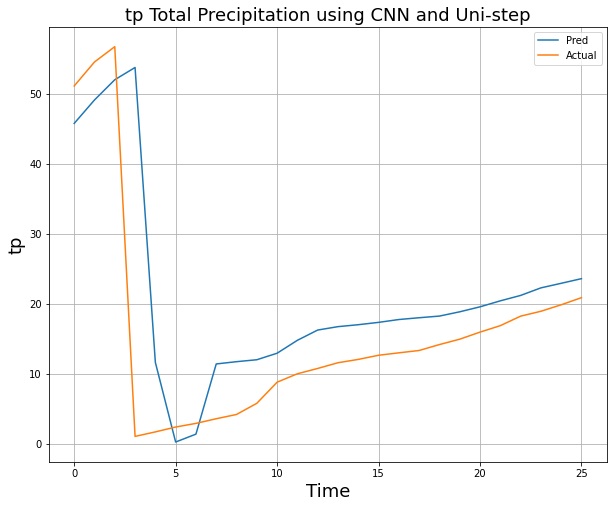

In [47]:
train('CNN', 'test')

In [48]:
train('LSTM')

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Training LSTM using Uni-step started with total epoch of 100.
Epoch [10/100]
Train Loss 0.0434
Val Loss 0.0165
 MAE : 0.1080
 MSE : 0.0165
RMSE : 0.1177
 MPE : -71.6539
MAPE : 104.9439
 R^2 : -20.3659
Saved model with best validation loss.
Epoch [20/100]
Train Loss 0.0398
Val Loss 0.0150
 MAE : 0.1001
 MSE : 0.0150
RMSE : 0.1110
 MPE : -78.1570
MAPE : 106.8752
 R^2 : -16.2403
Saved model with best validation loss.
Epoch [30/100]
Train Loss 0.0356
Val Loss 0.0136
 MAE : 0.0908
 MSE : 0.0136
RMSE : 0.1032
 MPE : -81.4763
MAPE : 107.0089
 R^2 : -13.1335
Saved model with best validation loss.
Epoch [40/100]
Train Loss 0.0330
Val Loss 0.0128
 MAE : 0.0852
 MSE : 0.0128
RMSE : 0.0984
 MPE : -83.0733
MAPE : 107.0546
 R^2 : -11.3288
Saved model with best validation loss.
Epoch [50/100]
Train Loss 0.0311
Val Loss 0.0122
 MAE : 0.0815
 MSE : 0.0122
RMSE : 0.0949
 MPE : -84.0365
MAPE : 107.2797
 R^2 : -9.9886
Saved model wit

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Test LSTM using Uni-step
 MAE : 6.4087
 MSE : 136.2918
RMSE : 7.7085
 MPE : -257.1203
MAPE : 260.1406
 R^2 : -1.4098


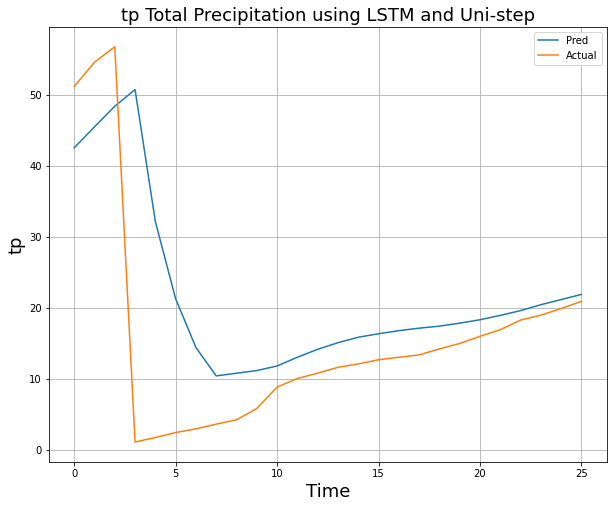

In [49]:
train('LSTM', 'test')

In [50]:
train('AttentionalLSTM')

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Training AttentionalLSTM using Uni-step started with total epoch of 100.
Epoch [10/100]
Train Loss 0.0398
Val Loss 0.0151
 MAE : 0.1002
 MSE : 0.0151
RMSE : 0.1105
 MPE : -74.9639
MAPE : 105.1234
 R^2 : -17.1828
Saved model with best validation loss.
Epoch [20/100]
Train Loss 0.0358
Val Loss 0.0134
 MAE : 0.0915
 MSE : 0.0134
RMSE : 0.1030
 MPE : -80.3710
MAPE : 106.0948
 R^2 : -13.3959
Saved model with best validation loss.
Epoch [30/100]
Train Loss 0.0310
Val Loss 0.0119
 MAE : 0.0804
 MSE : 0.0119
RMSE : 0.0931
 MPE : -82.8675
MAPE : 105.2853
 R^2 : -10.1968
Saved model with best validation loss.
Epoch [40/100]
Train Loss 0.0282
Val Loss 0.0110
 MAE : 0.0740
 MSE : 0.0110
RMSE : 0.0874
 MPE : -83.9389
MAPE : 104.8347
 R^2 : -8.3652
Saved model with best validation loss.
Epoch [50/100]
Train Loss 0.0262
Val Loss 0.0104
 MAE : 0.0691
 MSE : 0.0104
RMSE : 0.0832
 MPE : -84.4577
MAPE : 104.2229
 R^2 : -7.0475
Saved

(264, 1)
Train loader shape: 26
Val loader shape: 4
Test loader shape: 4
Test AttentionalLSTM using Uni-step
 MAE : 4.5755
 MSE : 104.4800
RMSE : 6.6976
 MPE : -206.3820
MAPE : 208.0604
 R^2 : -1.9708


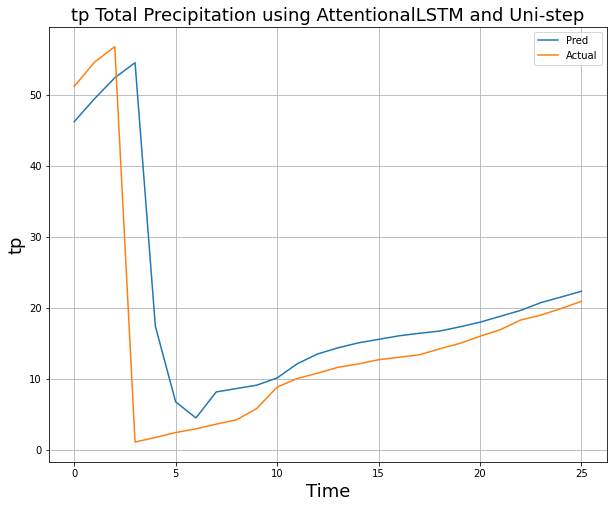

In [51]:
train('AttentionalLSTM', 'test')

In [52]:
# copy the models folder to the folder in the google drive
!cp -r weights/ /content/gdrive/My\ Drive/ATMS\ Project/univariate/weights/
# copy the plots folder to the folder in the google drive
!cp -r plots/ /content/gdrive/My\ Drive/ATMS\ Project/univariate/plots
# copy the numpy folder to the folder in the google drive
!cp -r numpy/ /content/gdrive/My\ Drive/ATMS\ Project/univariate/numpy


## Model Statistics on Test Data
- As we see above, all models have been evaluated on different metrics like MAE: Mean Average Error, MSE: Mean Squared Error, RMSE: Root MSE, MPE: Mean Percentage Error, MAPE: Mean Absolute Percentage Error, and $R^2$. 

- The lowest RMSE of all was seen in LSTM with Attention model (which pays attention to all previous time steps in various sequencees, kind of like correlation, and factor this in creating a good attention weight). 
- While this metric is okay, others like $R^2$ are negative (I looked online and found that $R^2$ can be negative too. ('https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2\_score.html')




## Inferring from Plots

- As we can see from the plots that the model has not learnt very well in the prediction of the rain in the next hour. 
- The plot looks like the predicted values are just actual values, but in different time steps. 
- The model has byhearted the data, which is not a good sign of robustness.

## Future Work

- Since the data of Mahad's total precipitation is lower, the model has not been able to train very well. 
- Here, I have used only 2021's data. From initial analysis and visualisation, we have seen that the rain fall pattern in similar in all years. 
- So, we will augment the data using 2019, 2020's data. This was the initial analysis of time series analysis. 
- We can now consider the multivariate analysis using these models with multi-step and multi-variate portions, especially with `Attentional LSTM`.
- We can also get similar clusters using `DeTSec` (Deep Multivariate Time Series Embedding Clustering via Attentive-Gated encoder) over our data. The authors have used it on ECG data.